<a href="https://colab.research.google.com/github/Cheralia/House-Price-Prediction/blob/main/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#references

dataset: https://www.kaggle.com/datasets/shree1992/housedata

#Library

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error
import shap
from scipy import stats #for z-score
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr
from sklearn.preprocessing import RobustScaler

#load dataset

In [2]:
file_path = "/content/drive/MyDrive/icog/Training/Training 1/Task/House price prediction/data.csv"
df = pd.read_csv(file_path)

In [3]:
df.shape

(4600, 18)

#Pre-processing

##check null, missing value & duplicate

In [4]:
df.info()
# Basic Checks
print("Missing values:\n", df.isnull().sum())

print("Duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

## outlier removal with Modified Z-score

Number of Outliers: 117


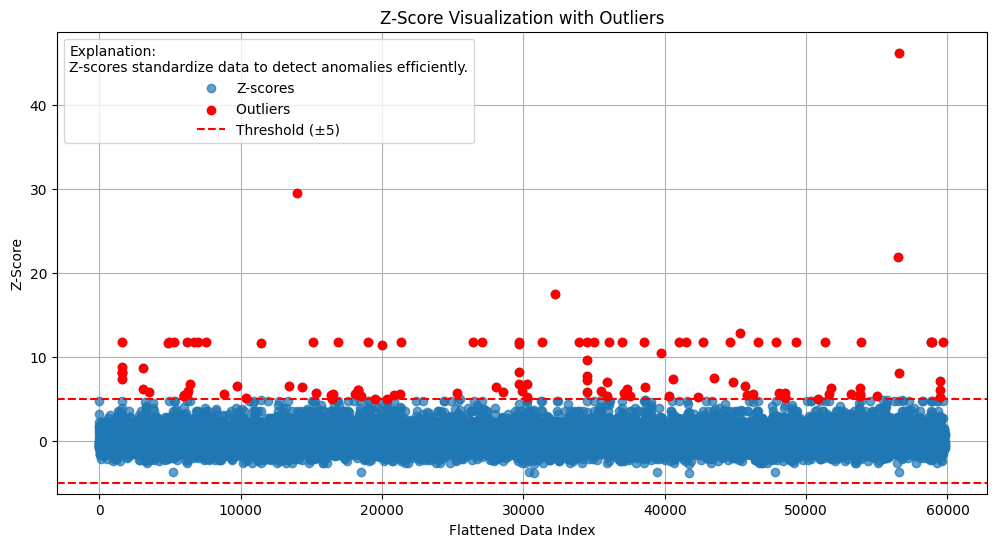

In [9]:

# Calculate Z-scores
z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))
# Convert Z-scores to DataFrame to retain column info and original index
z_scores_df = pd.DataFrame(z_scores, index=df.index, columns=df.select_dtypes(include=['float64', 'int64']).columns)

# Define a threshold
threshold = 5

# Identify individual outlier Z-scores
# An outlier Z-score is one where its absolute value is greater than the threshold
individual_outlier_z_scores = (z_scores_df.abs() > threshold)

# Count the number of individual outlier Z-scores
num_outliers = individual_outlier_z_scores.sum().sum() # Sum all True values across the DataFrame

print("Number of Outliers:", num_outliers)

# Plotting Z-scores
plt.figure(figsize=(12, 6))

# Flatten the Z-scores DataFrame for plotting all points, preserving original index
z_scores_flat = z_scores_df.stack() # Stacks columns into a single series, preserving MultiIndex

# Flatten the boolean mask in the same way
outlier_mask_flat = individual_outlier_z_scores.stack()

# Get the indices of the outlier Z-scores from the flattened mask
outlier_indices_flat = z_scores_flat.index[outlier_mask_flat]

# Get the outlier Z-score values using the boolean mask
outlier_z_scores = z_scores_flat[outlier_mask_flat]


# Plot all Z-scores - use range of length for x-axis to treat it as a continuous plot
plt.plot(range(len(z_scores_flat)), z_scores_flat.values, label='Z-scores', marker='o', linestyle='None', alpha=0.7)

# Highlight individual outlier Z-scores
# We need to map the MultiIndex from outlier_indices_flat to the 0-based integer index of the plot
# Create a mapping from the MultiIndex to the integer position in the stacked data
multiindex_to_int_pos = {idx: i for i, idx in enumerate(z_scores_flat.index)}
outlier_int_positions = [multiindex_to_int_pos[idx] for idx in outlier_indices_flat]


plt.scatter(outlier_int_positions, outlier_z_scores.values,
            color='red', label=f'Outliers ', zorder=5)

# Add threshold lines
plt.axhline(threshold, color='r', linestyle='--', label='Threshold (±5)', linewidth=1.5)
plt.axhline(-threshold, color='r', linestyle='--', linewidth=1.5)

# Add title and labels
plt.title('Z-Score Visualization with Outliers')
plt.xlabel('Flattened Data Index') # This index now refers to the position in the flattened data
plt.ylabel('Z-Score')

# Add legend with explanation
plt.legend(title="Explanation:\nZ-scores standardize data to detect anomalies efficiently.")

# Show grid and plot
plt.grid(True)
plt.show()


In [10]:
#remove outlier --
def clean_outliers_modified_z(df, threshold=3.5):
    cleaned = df.copy()
    for col in df.select_dtypes(include='number').columns:
        median = cleaned[col].median()
        mad = np.abs(cleaned[col] - median).median()
        if mad == 0:
            continue
        z = 0.6745 * (cleaned[col] - median) / mad
        cleaned = cleaned[(np.abs(z) <= threshold) & (cleaned[col] > 0)]
    return cleaned


cleandd = clean_outliers_modified_z(df, 5)
#removed data
print("removed data:", len(df) - len(cleandd))
cleandd.shape

removed data: 553


(4047, 18)

In [11]:
df = cleandd

## Feature Engineering

In [12]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
5,2014-05-02 00:00:00,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA


In [13]:
df["date"] = pd.to_datetime(df["date"])
df["yr_sold"] = df["date"].dt.year
df["month_sold"] = df["date"].dt.month

df["renovated"] = np.where(df["yr_renovated"] == 0, 0, 1)
df["yr_since_renovated"] = df.apply(
    lambda r: r["yr_sold"] - r["yr_built"] if r["yr_renovated"] == 0
    else r["yr_sold"] - r["yr_renovated"], axis=1
)

df["zip"] = df["statezip"].str.split(" ").str[1].astype(int)
df["sqft_per_bedroom"] = df["sqft_above"] / df["bedrooms"].replace(0, np.nan)
df["sqft_per_bathroom"] = df["sqft_above"] / df["bathrooms"].replace(0, np.nan)
df["living_to_lot_ratio"] = df["sqft_living"] / df["sqft_lot"]
df["basement"] = np.where(df["sqft_basement"] > 0, 1, 0)
df["rooms_per_floor"] = df["bedrooms"] / df["floors"]
df["total_bathrooms"] = df["bathrooms"] * df["floors"]
df["age_when_sold"] = df["yr_sold"] - df["yr_built"]
df["bath_bed_ratio"] = df["bathrooms"] / df["bedrooms"].replace(0, np.nan)
df["luxury_index"] = (df["sqft_living"] * df["bathrooms"]) / df["bedrooms"].replace(0, np.nan)
df["lot_per_floor"] = df["sqft_lot"] / df["floors"].replace(0, np.nan)
df["renovation_effect"] = np.where(df["renovated"] == 1, df["yr_since_renovated"], 0)

# Drop unnecessary columns
df.drop(columns=["country", "street", "date", "yr_sold", "yr_renovated", "statezip"], inplace=True, errors='ignore')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4047 entries, 0 to 4599
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                4047 non-null   float64
 1   bedrooms             4047 non-null   float64
 2   bathrooms            4047 non-null   float64
 3   sqft_living          4047 non-null   int64  
 4   sqft_lot             4047 non-null   int64  
 5   floors               4047 non-null   float64
 6   waterfront           4047 non-null   int64  
 7   view                 4047 non-null   int64  
 8   condition            4047 non-null   int64  
 9   sqft_above           4047 non-null   int64  
 10  sqft_basement        4047 non-null   int64  
 11  yr_built             4047 non-null   int64  
 12  city                 4047 non-null   object 
 13  month_sold           4047 non-null   int32  
 14  renovated            4047 non-null   int64  
 15  yr_since_renovated   4047 non-null   int64 

##Constant value column

In [15]:
# Check for non-changing value columns (constant columns)
constant_columns = []
for col in df.columns:
    if df[col].nunique() == 1:
        constant_columns.append(col)

if constant_columns:
    print("Columns with non-changing (constant) values:")
    for col in constant_columns:
        print(col)
else:
    print("No columns with non-changing (constant) values found.")

#remove constant column
df.drop(columns=constant_columns, inplace=True)

No columns with non-changing (constant) values found.


##Correlation matrix before encoding

Correlation with target:
 sqft_living            0.650495
luxury_index           0.609273
sqft_above             0.529968
bathrooms              0.488913
total_bathrooms        0.416604
sqft_per_bedroom       0.372314
view                   0.342068
bedrooms               0.319229
sqft_basement          0.300703
floors                 0.261239
bath_bed_ratio         0.245379
living_to_lot_ratio    0.216027
basement               0.198980
sqft_per_bathroom      0.111804
waterfront             0.078034
sqft_lot               0.070062
condition              0.065921
yr_since_renovated     0.034535
yr_built               0.012071
renovation_effect     -0.004926
age_when_sold         -0.012071
rooms_per_floor       -0.032763
zip                   -0.037410
renovated             -0.068806
lot_per_floor         -0.095321
dtype: float64 



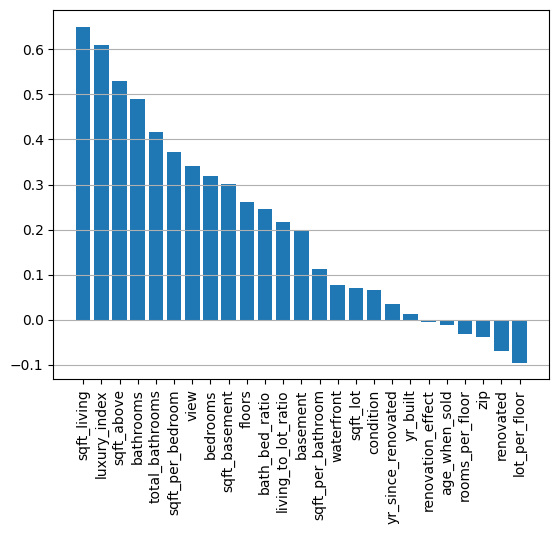

In [16]:
def check_linearity(df, target):

    # numeric features only
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target, errors='ignore')

    correlations = df[num_cols].corrwith(df[target]).sort_values(ascending=False)
    print("Correlation with target:\n", correlations, "\n")

    return correlations

correlations = check_linearity(df, target="price")



plt.bar(correlations.index, correlations.values)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

##corelation matrix of all numeric

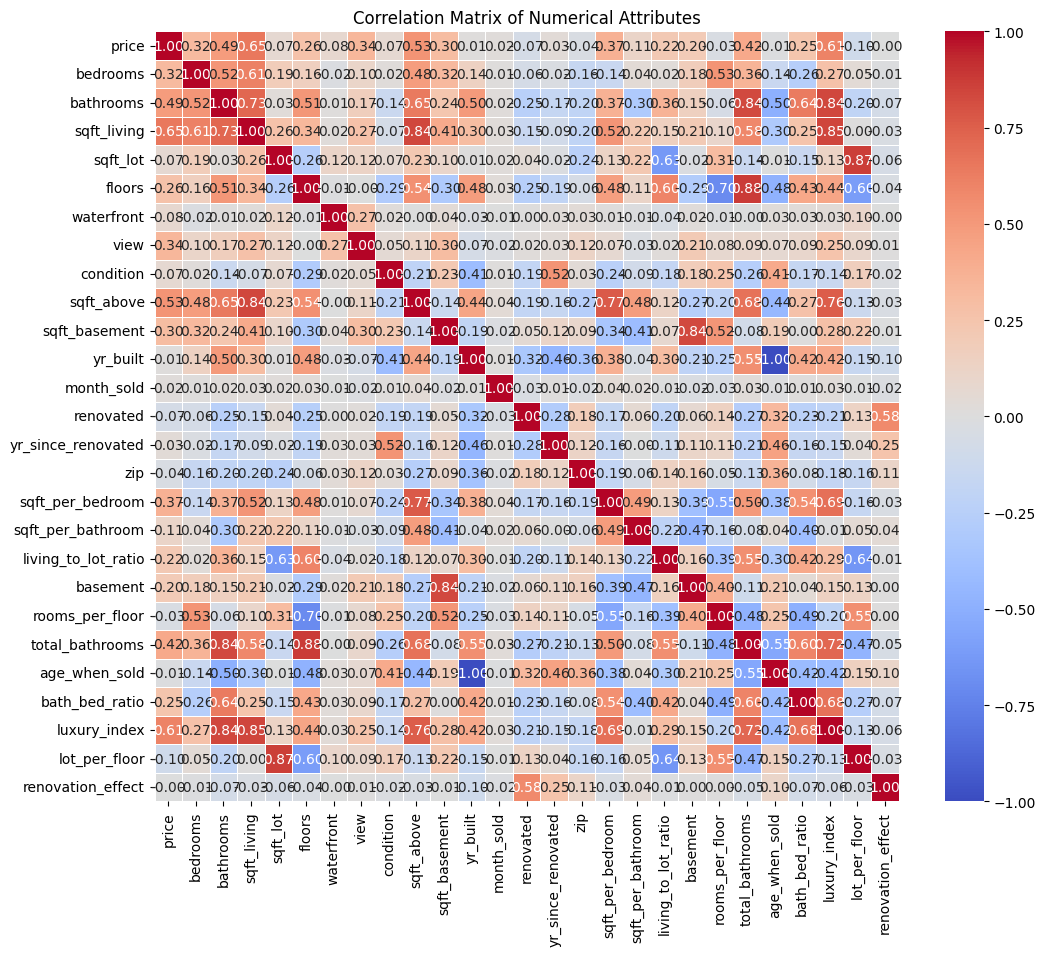

In [17]:
# Select only numerical columns for correlation matrix
numerical_df = df.select_dtypes(include=[np.number])
# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Attributes')
plt.show()

##Encode with dummy encoding

In [18]:
# Create a new DataFrame to store the encoded data
df_encoded = df.copy()

count_object = 0
converted_attriutes = []
# Iterate through each column in the DataFrame
for col in df.columns:
    if df[col].dtype == 'object':  # Check if the column is categorical
        count_object += 1
        converted_attriutes.append(col)
        # Use pd.get_dummies to encode the categorical column
        # dummy - encode the categorical column, and convert boolean to int and concatenate it with the original DataFrame
        dummy_encod = pd.get_dummies(df[col], prefix=col, drop_first=True).astype(int)
        df_encoded = pd.concat([df_encoded, dummy_encod], axis=1)

        # Drop the original categorical column from the DataFrame
        df_encoded.drop(col, axis=1, inplace=True)
df_encoded

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,313000.000000,3.0,1.50,1340,7912,1.5,0,0,3,1340,...,0,0,1,0,0,0,0,0,0,0
2,342000.000000,3.0,2.00,1930,11947,1.0,0,0,4,1930,...,0,0,0,0,0,0,0,0,0,0
3,420000.000000,3.0,2.25,2000,8030,1.0,0,0,4,1000,...,0,0,0,0,0,0,0,0,0,0
4,550000.000000,4.0,2.50,1940,10500,1.0,0,0,4,1140,...,0,0,0,0,0,0,0,0,0,0
5,490000.000000,2.0,1.00,880,6380,1.0,0,0,3,880,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,308166.666667,3.0,1.75,1510,6360,1.0,0,0,4,1510,...,0,1,0,0,0,0,0,0,0,0
4596,534333.333333,3.0,2.50,1460,7573,2.0,0,0,3,1460,...,0,0,0,0,0,0,0,0,0,0
4597,416904.166667,3.0,2.50,3010,7014,2.0,0,0,3,3010,...,0,0,0,0,0,0,0,0,0,0
4598,203400.000000,4.0,2.00,2090,6630,1.0,0,0,3,1070,...,0,1,0,0,0,0,0,0,0,0


In [19]:
df_encoded

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,313000.000000,3.0,1.50,1340,7912,1.5,0,0,3,1340,...,0,0,1,0,0,0,0,0,0,0
2,342000.000000,3.0,2.00,1930,11947,1.0,0,0,4,1930,...,0,0,0,0,0,0,0,0,0,0
3,420000.000000,3.0,2.25,2000,8030,1.0,0,0,4,1000,...,0,0,0,0,0,0,0,0,0,0
4,550000.000000,4.0,2.50,1940,10500,1.0,0,0,4,1140,...,0,0,0,0,0,0,0,0,0,0
5,490000.000000,2.0,1.00,880,6380,1.0,0,0,3,880,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,308166.666667,3.0,1.75,1510,6360,1.0,0,0,4,1510,...,0,1,0,0,0,0,0,0,0,0
4596,534333.333333,3.0,2.50,1460,7573,2.0,0,0,3,1460,...,0,0,0,0,0,0,0,0,0,0
4597,416904.166667,3.0,2.50,3010,7014,2.0,0,0,3,3010,...,0,0,0,0,0,0,0,0,0,0
4598,203400.000000,4.0,2.00,2090,6630,1.0,0,0,3,1070,...,0,1,0,0,0,0,0,0,0,0


#Method-1 correlation matrix

Correlation with target:
 sqft_living          0.650495
luxury_index         0.609273
sqft_above           0.529968
bathrooms            0.488913
total_bathrooms      0.416604
                       ...   
city_Maple Valley   -0.100565
city_Renton         -0.139953
city_Federal Way    -0.158628
city_Auburn         -0.171685
city_Kent           -0.171984
Length: 68, dtype: float64 



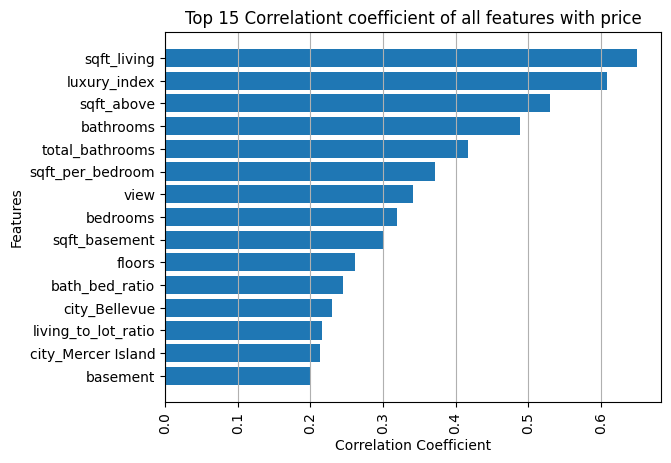

In [20]:
def check_linearity(df, target):

    # numeric features only
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target, errors='ignore')

    correlations = df[num_cols].corrwith(df[target]).sort_values(ascending=False)
    print("Correlation with target:\n", correlations, "\n")

    return correlations
correlations = check_linearity(df_encoded, target="price")

plt.title("Top 15 Correlationt coefficient of all features with price")
plt.barh(correlations.head(15).index, correlations.head(15).values)
plt.xticks(rotation=90)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

#train/test split

In [21]:
X = df_encoded.drop(["price"], axis=1)
y = df_encoded["price"]

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#LGB MODEL

##gridSearch

In [25]:
%%time

# Define the parameter grid to search
param_grid = {
    # 'num_leaves': [31, 63],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 300, 700],
    'max_depth': [5, 7, 11],
    # 'min_child_samples': [10, 20],
    # 'subsample': [ 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
}

# Setup the grid search
grid = GridSearchCV(
    estimator=LGBMRegressor(objective='regression', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',  # Use R-squared as the evaluation metric
    n_jobs=-1
)

# Fit the model
grid.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

#best model train evaluation
y_pred = best_model.predict(X_train)
y_true = y_train
#r2 value
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"Best Model Evaluation: r2 :{r2} and mae {mae}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 3237, number of used features: 51
[LightGBM] [Info] Start training from score 501561.529264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Evaluation

In [26]:

y_pred = best_model.predict(X_test)
y_true = y_test

test_r2 = r2_score(y_true, y_pred)
test_mae = mean_absolute_error(y_true, y_pred)

print(f"R²: {test_r2:.4f}")
print(f"MAE: {test_mae:.2f}")

R²: 0.7948
MAE: 78031.62


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


##Method-2 Buit in Feature Importance

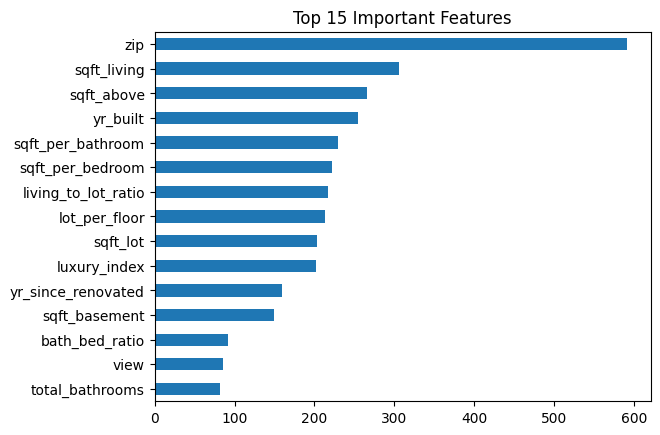

In [27]:
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(15).plot(kind="barh", title="Top 15 Important Features")
plt.gca().invert_yaxis()
plt.show()

##Method-3 SHAP Adaptive

In [31]:
lgb_model = best_model
# Create a DataFrame version of X_train for SHAP consistency
X_train_df_for_shap = pd.DataFrame(X_train, columns=X.columns)

# Create a tree explainer using the DataFrame version of X_train
lgb_explainer = shap.TreeExplainer(
    lgb_model, X_train_df_for_shap, feature_names=X.columns.tolist()
)

In [32]:
lgb_explainer

In [33]:
shap_values_lgb = lgb_explainer.shap_values(X_train_df_for_shap)

pd.DataFrame(shap_values_lgb, columns=X.columns.tolist()).head()

 96%|=================== | 3109/3237 [00:32<00:01]       

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,-2423.615386,3025.489559,-119243.825840,-30450.972070,1116.106143,0.0,-12331.077208,-8944.716119,-33232.060140,1898.793942,...,0.0,81644.078190,-129.048895,0.0,1211.651027,0.0,0.0,0.0,0.0,0.0
1,387.714273,3649.281214,196823.703920,15522.112593,-100.385540,0.0,-11355.365036,-7031.840483,24804.641568,11598.849408,...,0.0,-47869.165181,-103.448109,0.0,1970.555161,0.0,0.0,0.0,0.0,0.0
2,176.182512,207.596254,-77417.505673,6612.506435,-919.503215,0.0,-12019.876328,1892.371688,-8226.327978,2110.857199,...,0.0,-14924.138907,-144.464456,0.0,1641.813553,0.0,0.0,0.0,0.0,0.0
3,-706.627248,-802.293677,-105096.763216,8290.621371,-294.486947,0.0,-13199.899331,1244.801643,-5017.306987,661.871107,...,0.0,-21480.592837,-199.598659,0.0,1201.822189,0.0,0.0,0.0,0.0,0.0
4,-11821.774753,4785.701110,93744.629133,-1976.381207,1075.570850,0.0,-12304.866131,43038.015937,11353.712592,-9364.499343,...,0.0,81112.482837,-76.922796,0.0,1362.852933,0.0,0.0,0.0,0.0,0.0


In [34]:
shap_values_lgb.shape

(3237, 69)

In [35]:
# shap_values_lgb = shap_values_lgb[:, :]

pd.DataFrame(shap_values_lgb, columns=X.columns.tolist()).head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,-2423.615386,3025.489559,-119243.825840,-30450.972070,1116.106143,0.0,-12331.077208,-8944.716119,-33232.060140,1898.793942,...,0.0,81644.078190,-129.048895,0.0,1211.651027,0.0,0.0,0.0,0.0,0.0
1,387.714273,3649.281214,196823.703920,15522.112593,-100.385540,0.0,-11355.365036,-7031.840483,24804.641568,11598.849408,...,0.0,-47869.165181,-103.448109,0.0,1970.555161,0.0,0.0,0.0,0.0,0.0
2,176.182512,207.596254,-77417.505673,6612.506435,-919.503215,0.0,-12019.876328,1892.371688,-8226.327978,2110.857199,...,0.0,-14924.138907,-144.464456,0.0,1641.813553,0.0,0.0,0.0,0.0,0.0
3,-706.627248,-802.293677,-105096.763216,8290.621371,-294.486947,0.0,-13199.899331,1244.801643,-5017.306987,661.871107,...,0.0,-21480.592837,-199.598659,0.0,1201.822189,0.0,0.0,0.0,0.0,0.0
4,-11821.774753,4785.701110,93744.629133,-1976.381207,1075.570850,0.0,-12304.866131,43038.015937,11353.712592,-9364.499343,...,0.0,81112.482837,-76.922796,0.0,1362.852933,0.0,0.0,0.0,0.0,0.0


###Global interpretability

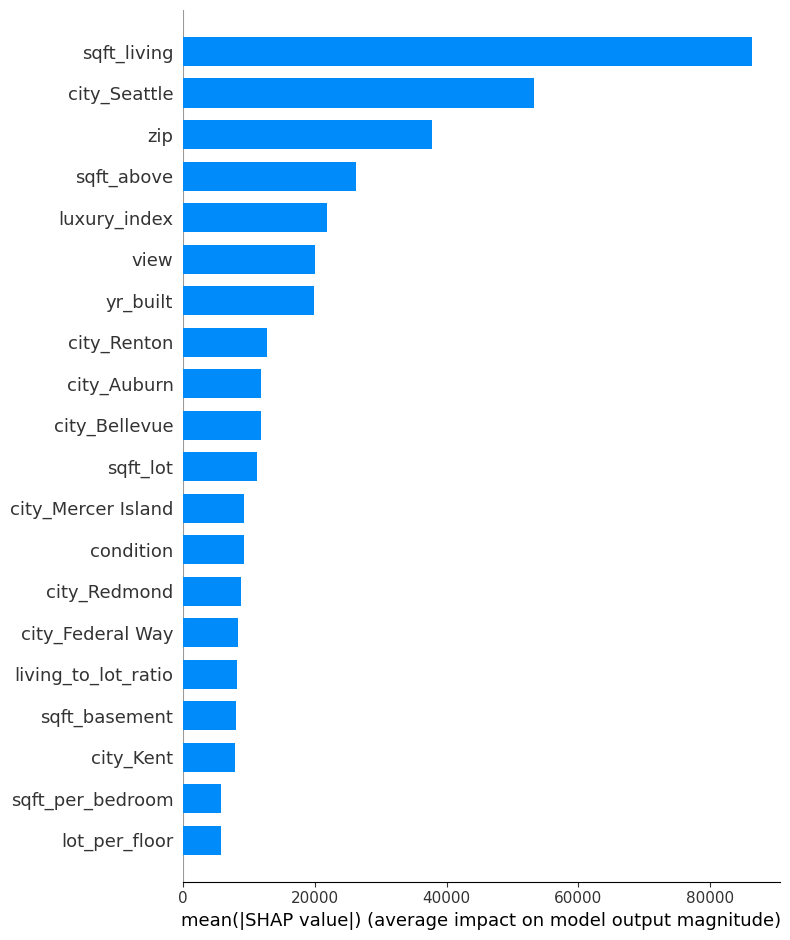

In [36]:
shap.summary_plot(
    shap_values_lgb, X_train, feature_names=X.columns, plot_type="bar"
)

In [37]:
pd.DataFrame(shap_values_lgb, columns=X.columns)["sqft_living"].abs().mean()

np.float64(86303.63100833987)

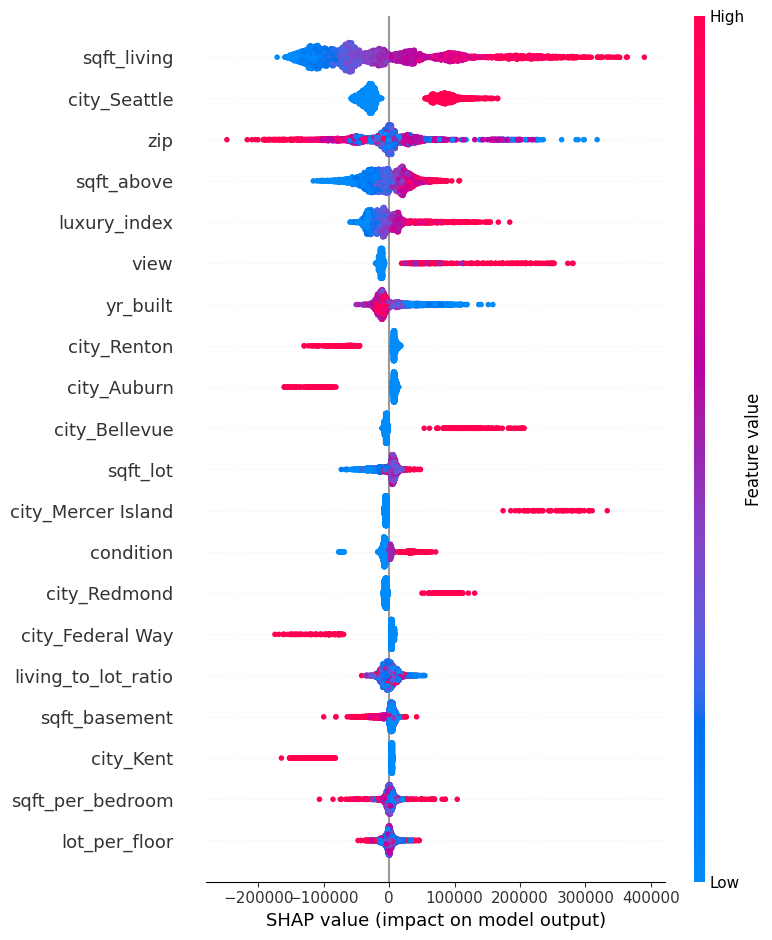

In [38]:
shap.summary_plot(shap_values_lgb, X_train, feature_names=X.columns);

In [39]:
print(f"{shap_values_lgb.shape} X:{X_train.shape}")

(3237, 69) X:(3237, 69)


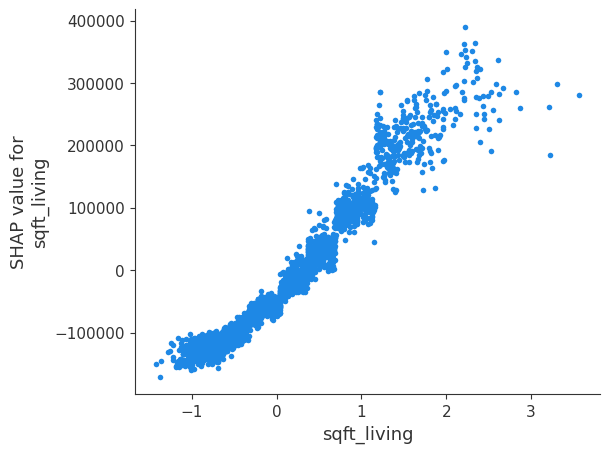

In [40]:
shap.dependence_plot('sqft_living', shap_values_lgb, X_train_df_for_shap, interaction_index=None)

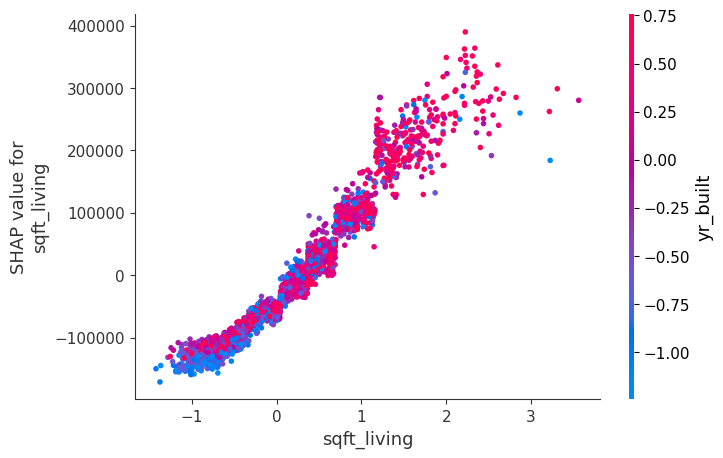

In [41]:
shap.dependence_plot("sqft_living", shap_values_lgb, X_train_df_for_shap, interaction_index="auto");

It seems that the sqft_living interacts with the sqft_lot of the diamonds much stronger than other features.

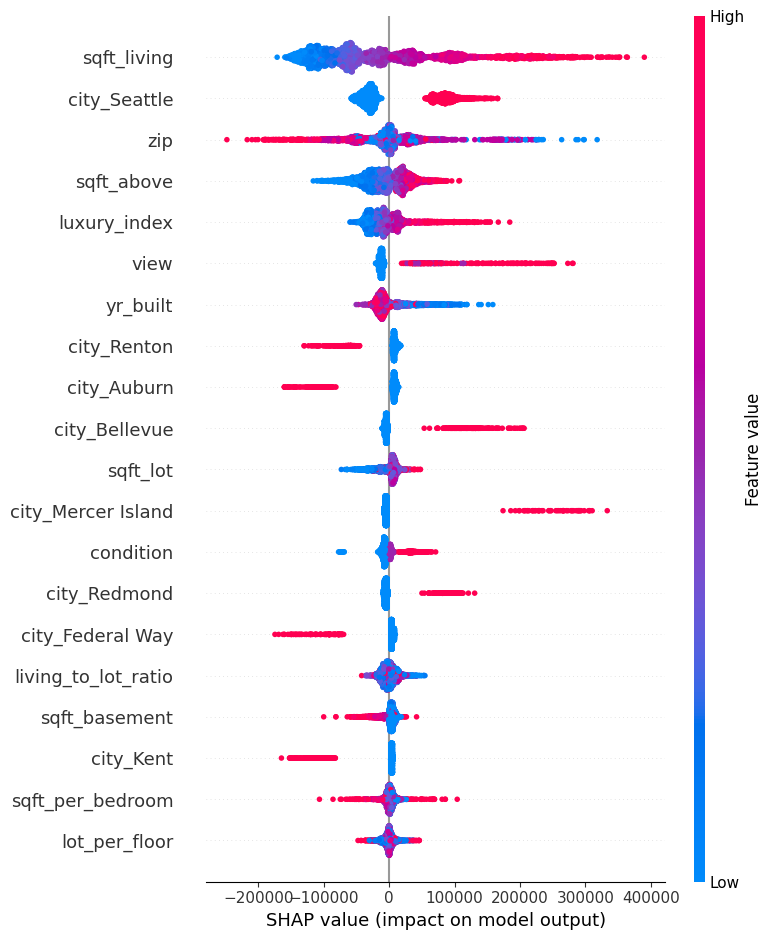

In [42]:
shap.summary_plot(shap_values_lgb, X_train_df_for_shap, feature_names=X.columns);

###Local interpretability

In [43]:
%%time

# Recalculate SHAP values
shap_explainer_values = lgb_explainer(X_train, y_train)

 96%|=================== | 3110/3237 [00:26<00:01]       

CPU times: user 25.3 s, sys: 64.4 ms, total: 25.3 s
Wall time: 26.4 s


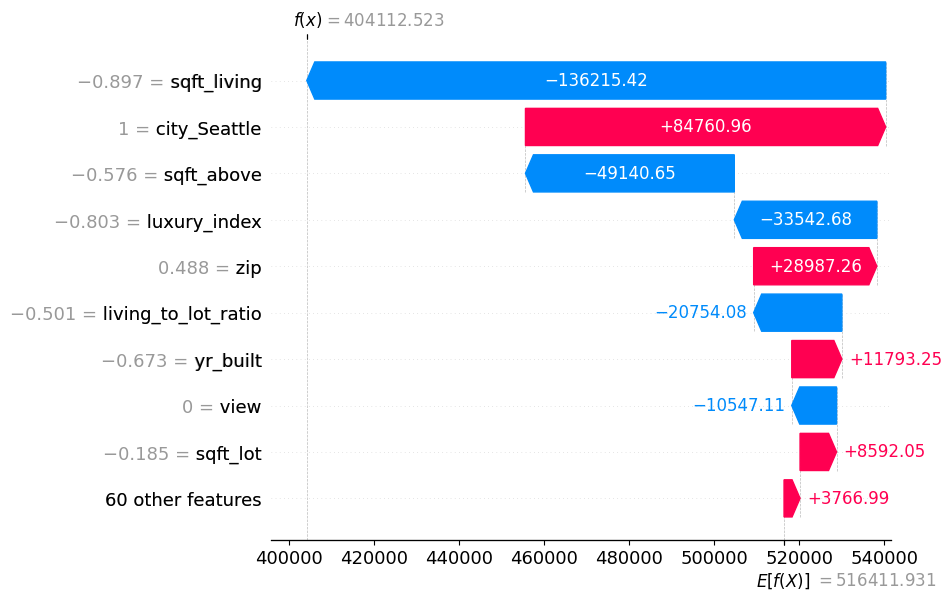

In [44]:
shap.waterfall_plot(shap_explainer_values[559])

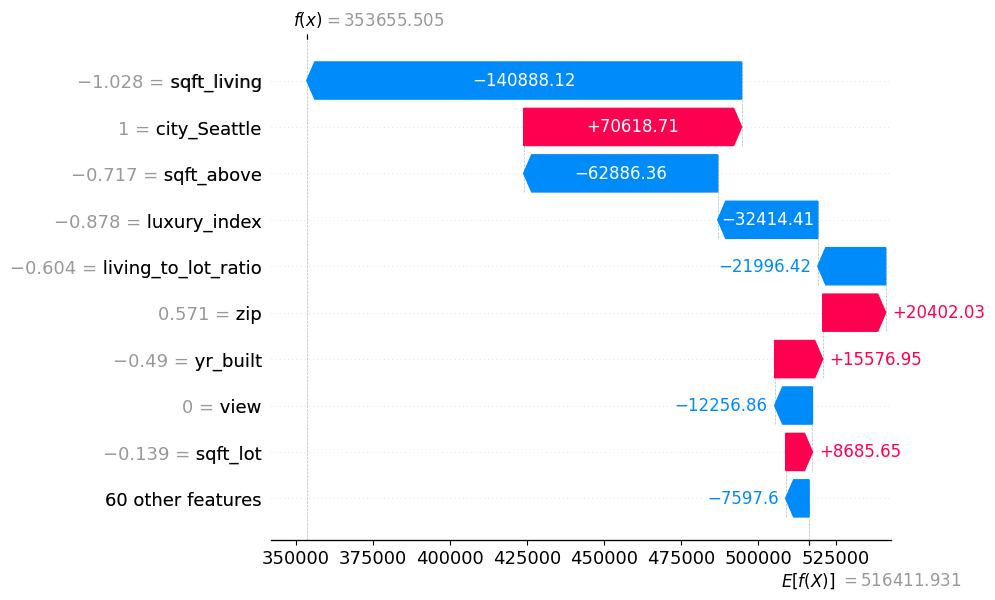

In [45]:
shap.waterfall_plot(shap_explainer_values[3100])

In [47]:
shap.initjs()

shap.force_plot(shap_explainer_values[559])

In [48]:
shap.initjs()

shap.force_plot(shap_explainer_values[3100])

In [49]:
# Create a DataFrame version of X_test for SHAP consistency
X_test_df_for_shap = pd.DataFrame(X_test, columns=X.columns)

# Select two individual instances from the test set
instance_1 = X_test_df_for_shap.iloc[[10]] # First instance

# Calculate SHAP values for these individual instances
shap_values_instance_1 = lgb_explainer.shap_values(instance_1)

# Get the expected value (base value) from the explainer
expected_value = lgb_explainer.expected_value

print("Local explanation for Instance 1:")
shap.initjs()
shap.force_plot(expected_value, shap_values_instance_1, instance_1)


Local explanation for Instance 1:
